In [5]:
root="C:/github/2023/RatDeconvolution"

# Clustering

In [31]:
import warnings
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import statsmodels.stats.multitest as sm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = 16
warnings.simplefilter('ignore')

In [45]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

def load(target_compounds, median=True):
    # Deconvolution
    df_alt = pd.read_csv(f"{root}/data/tggate_biochemical_values.csv", index_col=0)
    df_alt = calc_z(df_alt.T, drugs=target_compounds, ctrl="ctrl")
    df_alt.index = [i.split("_rep")[0] for i in df_alt.index]
    df_alt = df_alt.loc[:,['ALT(IU/L)',]]
    df_alt.columns = ["ALT"]
    df_alt.index=[i.split(" h")[0] + " hr" for i in df_alt.index]
    if median:
        df_alt = df_alt.groupby(level=0,axis=0).median()

    df = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
    df = df.loc[(df.index.str.contains("High")) | (df.index.str.contains("Control")),:]
    df = df.loc[~(df.index.str.contains("day")),:]
    df_z = calc_z(df, drugs=target_compounds, ctrl="Control")
    if median:
        df_z = df_z.groupby(axis=0, level=0).mean()
    return df_z, df_alt

def create_table(df, target_compounds, preprocessing=None, pros_lst=True):
    times = ["3 hr", "6 hr", "9 hr", "24 hr"]
    lst_features = []
    for feat in df.columns:
        lst_features.extend([f"{feat}_{time}" for time in times])

    df_time = pd.DataFrame(index=lst_features, columns=target_compounds)
    for comp in target_compounds:
        lst_feat_all = []
        for feat in df.columns:
            lst_feat = df.loc[[f"{comp}_High_{time}" for time in times],feat].tolist()
            if pros_lst:
                lst_feat = preprocessing(lst_feat)
            lst_feat_all.extend(lst_feat)
        df_time[comp]=lst_feat_all
    df_time = df_time.T
    if not pros_lst:
        df_time= df_time.apply(preprocessing)
    return df_time

def minmax(lst):
    scaler = MinMaxScaler()
    return [i[0] for i in list(scaler.fit_transform(np.array(lst).reshape(-1, 1)))]

def max_one(lst):
    return [i/max(lst) for i in lst]

def raw(lst):
    return lst

def z_conv(lst):
    scaler = StandardScaler()
    return [i[0] for i in list(scaler.fit_transform(np.array(lst).reshape(-1, 1)))]

def pca_plot(df, lst_cluster, ax=None):
    colors= ["firebrick", "darkblue", "darkgreen", "grey"]
    df_res = pd.DataFrame(index=df.index.tolist())
    df_res["Cluster_ID"]=lst_cluster
    model = PCA(n_components=2, random_state=0)
    x_embedded = model.fit_transform(df.values)
    df_res["0"]=x_embedded.T[0]
    df_res["1"]=x_embedded.T[1]
    for i, color in enumerate(colors):
        df_temp=df_res[df_res["Cluster_ID"]==i]
        ax.plot(df_temp["0"], df_temp["1"], color=color, markersize=8, linestyle="None", marker="o",)
    ax.set_title("PCA")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

def tsne_plot(df, lst_cluster, ax=None, perplexity=5):
    colors= ["firebrick", "darkblue", "darkgreen", "grey"]
    df_res = pd.DataFrame(index=df.index.tolist())
    df_res["Cluster_ID"]=lst_cluster
    model = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    x_embedded = model.fit_transform(df.values)
    df_res["TSNE_0"]=x_embedded.T[0]
    df_res["TSNE_1"]=x_embedded.T[1]
    for i, color in enumerate(colors):
        df_temp=df_res[df_res["Cluster_ID"]==i]
        ax.plot(df_temp["TSNE_0"], df_temp["TSNE_1"], color=color, markersize=8, linestyle="None", marker="o",)
    ax.set_title(f"TSNE: {perplexity}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

def umap_plot(df, lst_cluster, ax=None, n_neighbors=5):
    colors= ["firebrick", "darkblue", "darkgreen", "grey"]
    df_res = pd.DataFrame(index=df.index.tolist())
    df_res["Cluster_ID"]=lst_cluster
    model = umap.UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors)
    x_embedded = model.fit_transform(df.values)
    df_res["Cluster_ID"]=lst_cluster
    df_res["0"]=x_embedded.T[0]
    df_res["1"]=x_embedded.T[1]
    for i, color in enumerate(colors):
        df_temp=df_res[df_res["Cluster_ID"]==i]
        ax.plot(df_temp["0"], df_temp["1"], color=color, markersize=8, linestyle="None", marker="o",)
    ax.set_title(f"UMAP: {n_neighbors}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [33]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]

clusters = [
    ["naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril","gefitinib","metformin","tiopronin",],
    ["colchicine","bortezomib","methylene dianiline","galactosamine","thioacetamide",],
    ["LPS","cycloheximide"],["tacrine","nitrofurazone"],
]

lst_target = [
    "Neu",
    "Mon",
    "CD4T",
    "CD8T",
]

In [34]:
df, _ = load(target_compounds)
df = df.loc[:,lst_target]
df_time = create_table(df, target_compounds, preprocessing=raw, pros_lst=False)

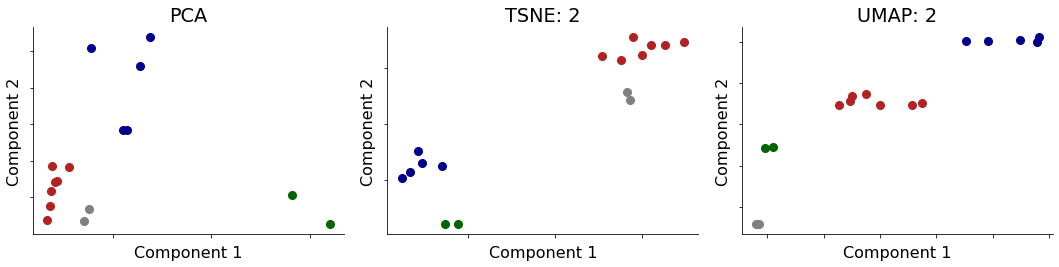

In [35]:
df_time = df_time.loc[clusters[0]+clusters[1]+clusters[2]+clusters[3],:]
lst_cluster=[0]*len(clusters[0])+[1]*len(clusters[1])+[2]*len(clusters[2])+[3]*len(clusters[3])
# PCA
fig = plt.figure(figsize=(15,4))
ax=fig.add_subplot(131)
pca_plot(df_time, lst_cluster, ax=ax)
ax=fig.add_subplot(132)
tsne_plot(df_time, lst_cluster, ax=ax, perplexity=2)
ax=fig.add_subplot(133)
umap_plot(df_time, lst_cluster, ax=ax, n_neighbors=2)
plt.tight_layout()
plt.show()

## Cluster information

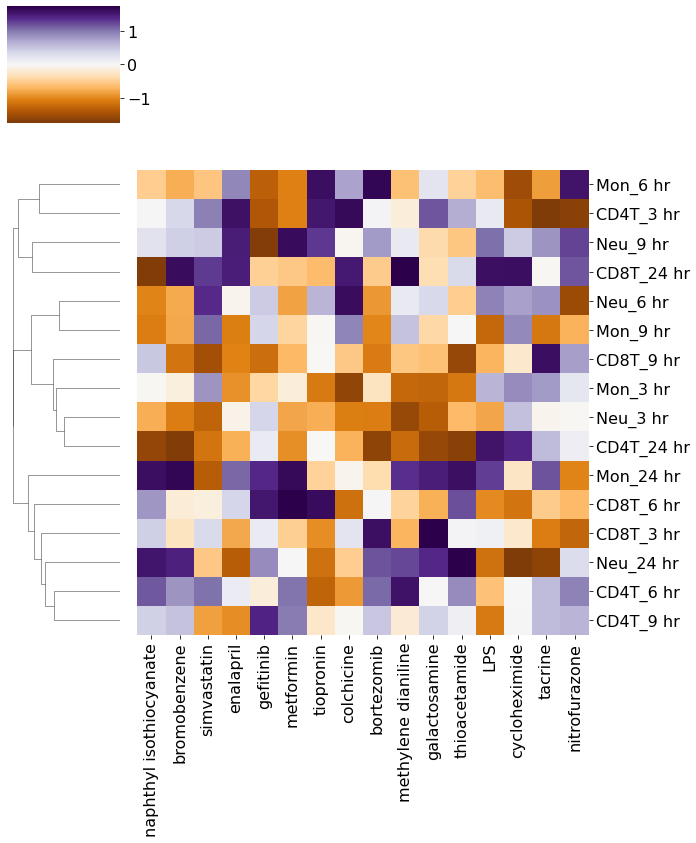

In [36]:
df, _ = load(target_compounds)
df = df.loc[:,lst_target]
df_time = create_table(df, target_compounds, preprocessing=z_conv)
df_time = df_time.loc[clusters[0]+clusters[1]+clusters[2]+clusters[3],:]

sns.clustermap(df_time.T, col_cluster=False, cmap="PuOr", figsize=(10, 12))
plt.tight_layout()
plt.show()

## Average Moving

In [53]:
def calc_stat(df):
    lst_time = ["3 hr", "6 hr", "9 hr", "24 hr"]
    df_res = pd.DataFrame(index=df.columns, columns=lst_time)
    for time in lst_time:
        for target in df.columns.tolist():
            values = df.loc[df.index.str.contains(time),target].values.flatten()
            v_mean = np.mean(values)
            v_conf = stats.t.interval(alpha=0.95, df=len(values)-1, loc=v_mean, scale=stats.sem(values))
            df_res.loc[target, time]=[v_mean, v_conf[0], v_conf[1]]
    return df_res

In [54]:
temp_lst = [
    "ALT",
    "Neu",
    "Mon",
    "CD4T",
    "CD8T",
]
lst_time = ["3 hr", "6 hr", "9 hr", "24 hr"]
colors=[
    ["firebrick", "salmon"],
    ["darkblue", "lightblue"],
    ["darkgreen","lightgreen"],
    ["black", "lightgrey"],
]

In [59]:
df_d, df_b = load(target_compounds, median=False)
lst_df_stat=[]
for cluster in clusters:
    df_temp = pd.concat([df_d[df_d.index.str.contains(comp)] for comp in cluster], axis=0)
    df_stat = calc_stat(df_temp)
    df_temp = pd.concat([df_b[df_b.index.str.contains(comp)] for comp in cluster], axis=0)
    df_stat = pd.concat([df_stat, calc_stat(df_temp)], axis=0)
    lst_df_stat.append(df_stat)

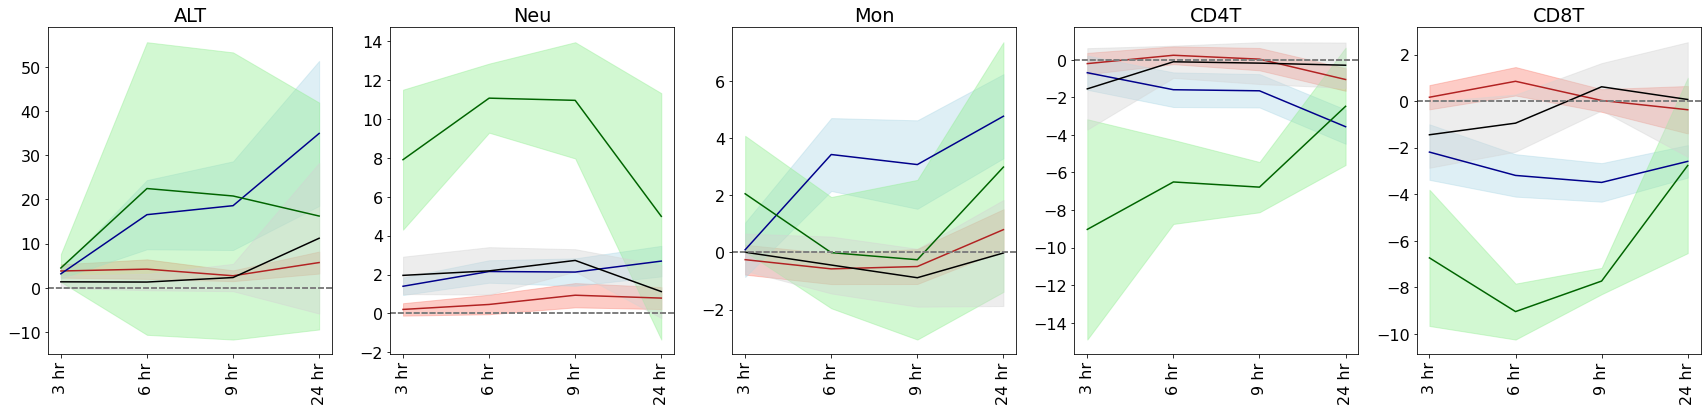

In [62]:
fig = plt.figure(figsize=(24,6))
for x, temp in enumerate(temp_lst):
    ax=fig.add_subplot(1,5,x+1)
    for v in range(4):   
        v_mean = [i[0] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_upper = [i[1] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_lower = [i[2] for i in lst_df_stat[v].loc[temp,:].tolist()]
        ax.plot(range(4), v_mean, color=colors[v][0])
        ax.axhline(0, color="grey", linestyle="dashed")
        ax.fill_between(range(4), v_lower, v_upper, color=colors[v][1], alpha=0.4)
    ax.set_xticks(range(4))
    ax.set_xticklabels(lst_time, rotation=90, fontsize=16)
    #ax.set_xlim(-1,4)
    ax.set_title(temp)
plt.tight_layout()
plt.show()